# Localize

Localize is an UI used to clean the data from a session cut in epochs. It takes in input the folder coming from Neuralynx, an info yaml filled manually and optionally another tracking data file (saw localize guide) and gives in output the position (HDF5 + yaml file) for each epoch. This output can be used then by the ui called Amaze. 

Here, we want to go throughout the localize algorithm without using the ui. It could be used to debug but also if we want to integrate it in a bigger workflow.

However, the first part consisting to draw regions to exclude or include data, it is difficult to do without an ui. The following algorithm will begin right next this step. It means that the "epoch" folder + the epoch yaml file (with the region selected) have been already generated by the ui.

you can found some documentation about the GUI version of localize [here](../../new_analysis/localize.rst)

## Data calibration

To calibrate the data, you need to add at the root of the session a calibration file generated by using the camera calibration ui (or the algorithm showed in the previous notebook). 

Note: for practical reason, the regions drawn in the localize are always define in pixels (without calibration) and only the include date is calibrated. 

## Import libraries

In [1]:
import os
import collections
import numpy as np
import seaborn
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure

from fklab.behavior.target_tracker import (
    DeeplabcutTargetTracker,
    NlxSingleTargetTracker,
)
from fklab.ui.localize.localize_controller import Controller

import fklab.utilities.yaml as yaml
from fklab.segments import Segment
import fklab.plot

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
import pathlib

root_path = pathlib.Path("~/notebook_data_cache").expanduser()
session_path = root_path.joinpath("localize")

info_path = session_path.joinpath("info.yaml")
source_path = session_path.joinpath("VT1DLC.h5")
data_path = session_path.joinpath("VT1.nvt")

if not session_path.exists():
    session_path.mkdir(parents=True)

if not info_path.exists() or not source_path.exists():
    from fklab.io.cloud import dropboxAPI

    dbx = dropboxAPI.from_token(
        os.environ.get("BITBUCKET_TOKEN")
    )  # Replace by your own token
    dbx.download("/Data/localize/info.yaml", info_path)
    dbx.download("/Data/localize/VT1DLC.h5", source_path)

## Initialization: loading configuration files and data

## Create data from an session (option 1)

**step 1**: load the info.yaml: containing all information about the session and the differents epochs

**step 2**: create epoch folders at the epoch location given 

**step 3**: if position.yaml is already existing at this location
- step 3a : load the computation options set in the last session 
- step 3b : or create a new file with the standard option
    
**step 4**: Create the tracker 
- step 4a: Create the tracker based on the presence (nlxsingletracker) or not(deeplabcuttracker) of the VT1.nvt file
- step 4b: Load the option if existing (position.yaml in the epoch folder)
- step 4c: Load the data 

In [3]:
# Open the info yaml to read the information about the epoch

# create save folder for the epochs
# in the ui, there are a standard path : current_session/epochs/name_epoch/position.*
# but you can specify in other path
# Finally, it will create the tracker with the first epoch found the info.yaml epoch list.
#
# Set the path of the session containing the raw data
controller = Controller()

controller.paths.set_infopath(session_path)

tracker = controller.update_tracker()

print(controller.paths.datapath)
print(controller.paths.epochpath)
print(controller.paths.epoch_selected)

print(tracker)

/home/chaputmarine/notebook_data_cache/localize
/home/chaputmarine/notebook_data_cache/localize/epochs
training


## Create data from an epoch (option 2)

**step 1**: load the position yaml

**step 2**: recover the raw data path from the options["source]["path"] or by testing via the default path (info.yaml present in two levels folder upper epoch path)

**step 3**: load the info yaml 

**step 4**: Create the tracker 
- step 4a: Create the tracker based on the presence (nlxsingletracker) or not(deeplabcuttracker) of the VT1.nvt file
- step 4b: Load the option if existing (position.yaml in the epoch folder)
- step 4c: Load the data 

In [4]:
# Set the path of the session containing the raw data
controller = Controller()

controller.paths.epochpath = os.path.join(session_path, "epochs", "training")

tracker = controller.update_tracker()
controller.load_options()

print(controller.paths.datapath)
print(controller.paths.epochpath)
print(controller.paths.epoch_selected)

print(tracker)

/home/chaputmarine/notebook_data_cache/localize
/home/chaputmarine/notebook_data_cache/localize/epochs
training


## Compute the position from the video image

### Define the graph tracker and load a calibration file

In [5]:
# load an existing calibration file
local_calib_path = os.path.join(os.path.dirname(session_path), "calibration.yaml")
if os.path.exists(local_calib_path):
    controller.load_calibration(local_calib_path)

# the calibration file is not yet at the root of the session folder - you need to load it
local_calib_path = os.path.join(os.path.dirname(session_path), "calibration.yaml")
orig_calib_path = "./calibration.yaml"
if os.path.exists(orig_calib_path):
    controller.load_calibration(local_calib_path, orig_calib_path=orig_calib_path)

### Set the computation options

In [7]:
# Set the diode orientation
orientation = 0.75
tracker.set_orientation(orientation)

# correct diode distance
tracker.set_correction_options("diode_distance", threshold=float(0.25))
tracker.set_correction_options("diode_distance", enabled=True)


# missing diode interpolation
tracker.set_correction_options("missing_diode", gap_size=float(0.25))
tracker.set_correction_options("missing_diode", enabled=True)

# regions => Regions can be only modifiable in the ui. here we can only accept or remove all
tracker.set_regions_options(enabled=True)

# remove jumps
tracker.set_correction_options("jumps", size=int(20))  # value in pixel
tracker.set_correction_options("jumps", duration=float(0.50))  # value in second
tracker.set_correction_options("jumps", enabled=True)

# small gap interpolation
tracker.set_correction_options("small_gaps", gap_size=float(0.10))  # in second
tracker.set_correction_options("small_gaps", enabled=True)

# final gap interpolation
tracker.set_correction_options("large_gaps", gap_size=float(0.50))  # in second
tracker.set_correction_options("large_gaps", enabled=True)

# robust position parameter
tracker.set_behavior_options(velocity_smooth=float(0.25))  # in second
tracker.set_behavior_options(direction_smooth=float(0.50))  # in second
tracker.set_behavior_options(robust=True)

# time windows to exclude
# time windows
tracker.set_correction_options("time_windows", enabled=True)

# windows = Segment([[1300, 1340], [13620.0, 13621.0]])  # Set the time window here

# tracker.set_correction_options(
#    "time_windows", windows=windows.asarray().tolist(), enabled=True
# )

## Plot the result

### Plot the positions of the animal in the maze

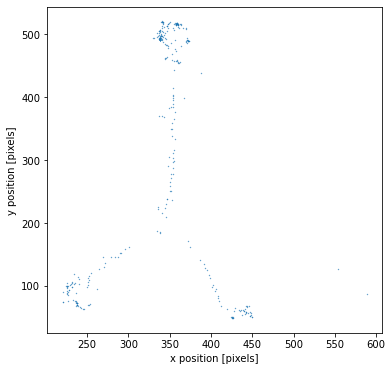

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

update, behav = tracker.behavior

maze_figure = plt.figure(figsize=(6, 6))
axis = maze_figure.add_subplot(111)
axis.set_xlabel("x position [pixels]")
axis.set_ylabel("y position [pixels]")


if tracker.calib_exist:
    axis.scatter(
        behav["position"][:, 0] / tracker._px2cm,
        behav["position"][:, 1] / tracker._px2cm,
        s=0.1,
    )
else:
    axis.scatter(behav["position"][:, 0], behav["position"][:, 1], s=0.1)


# Add regions :
for k in tracker.get_regions_option("include"):
    col, highlight = "green", "limegreen"
    artist = fklab.plot.iPolygon(
        k.vertices,
        color=col,
        facecolor="none",
        zorder=100,
        highlight_color=highlight,
        linewidth=2,
        alpha=0.3,
    )
    artist.interactive = False
    axis.add_patch(artist)

for k in tracker.get_regions_option("exclude"):
    col, highlight = "red", "salmon"
    artist = fklab.plot.iPolygon(
        k.vertices,
        color=col,
        facecolor="none",
        zorder=100,
        highlight_color=highlight,
        linewidth=2,
        alpha=0.3,
    )
    artist.interactive = False
    axis.add_patch(artist)

maze_figure.show()

### Plot the evaluation figure

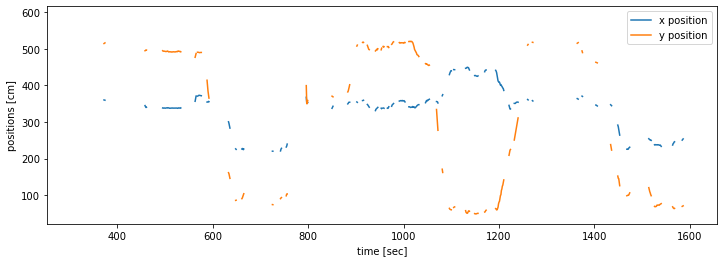

In [9]:
position_figure = plt.figure(figsize=(12, 4))
axis = position_figure.add_subplot(111)
axis.set_xlabel("time [sec]")
axis.set_ylabel("positions [cm]")

axis.plot(behav["time"], behav["position"][:, 0], label="x position")
axis.plot(behav["time"], behav["position"][:, 1], label="y position")
axis.legend()

In [ ]:
# plot speed, head direction vs tim
speed_figure = plt.figure(figsize=(12, 3))
axis = speed_figure.add_subplot(111)
axis.set_xlabel("time [sec]")
axis.set_ylabel("velocity [cm/sec]")
speed = np.abs(behav["velocity"])
axis.plot(behav["time"], speed)

In [ ]:
# plot position and speed
fig = plt.figure(figsize=(12, 8))

axis_1 = fig.add_subplot(2, 1, 1)
axis_1.plot(behav["time"], speed, color="red", label="velocity")
axis_1.set_xlabel("time [sec]")
axis_1.set_ylabel("velocity [cm/sec]")
axis_1.legend()

axis_2 = fig.add_subplot(2, 1, 2, sharex=axis_1)
axis_2.set_ylabel("positions [cm]")
axis_2.plot(behav["time"], behav["position"][:, 1], label="x position")
axis_2.plot(behav["time"], behav["position"][:, 0], label="y position")

axis_2.legend()

In [ ]:
head_figure = plt.figure(figsize=(12, 4))
axis = head_figure.add_subplot(111)
axis.set_xlabel("time [sec]")
axis.set_ylabel("head direction [deg]")
axis.plot(behav["time"], 180.0 * behav["head_direction"] / np.pi)

In [ ]:
# plot move direction - head direction distribution

hist_figure = plt.figure(figsize=(12, 4))
axis = hist_figure.add_subplot(111)

speed_threshold = np.nanpercentile(speed, 70)
direction = fklab.statistics.circular.diff(
    np.angle(behav["velocity"]), behav["head_direction"], directed=True
)
direction = direction[
    np.logical_and(np.logical_not(np.isnan(direction)), speed > speed_threshold)
]
if len(direction) > 0:
    seaborn.distplot(180.0 * direction / np.pi, bins=100, ax=axis, kde=False)

This figure shows a histogram of the difference between the head position and the velocity direction. It should be around zero except if the head direction has been wrongly specified in the option. 

## Save - Generate the position.h5 and the position.yaml

position.h5 is a dataset containing:

- time
- position (x/y)
- velocity
- head direction

In [ ]:
controller.save()